## Reimplementing Faster R-CNN using TensorFlow.

### Steps
 1. Create the convolutional layers, by taking a model pretrained on ImageNet and use Transfer Learning.


### Resources

 For transfer learning from MobileNet V2:
 1. https://www.tensorflow.org/tutorials/images/transfer_learning
 2. https://www.tensorflow.org/tutorials/images/transfer_learning
 3. https://arxiv.org/pdf/1506.01497.pdf
 4. https://www.youtube.com/watch?v=nDPWywWRIRo
 
### TODO 
While doing the classification, fix the imbalanced dataset by adding weights to labels.

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
tf.compat.v1.enable_eager_execution()

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# TODO Should I filter out only the "traffic" categories? ex: cars, bikes, person
# TODO: Apply normalization to the input dataset
dataset = tfds.load(name="voc", split=tfds.Split.TRAIN)

classes = [ 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 
            'Bus', 'Car', 'Cat', 'Chair', 'Cow', 
            'Diningtable', 'Dog', 'Horse', 'Motorbike', 'Person', 
            'Pottedplant', 'Sheep', 'Sofa', 'Train', 'Tvmonitor']

In [3]:
# DIFFERENT:In the paper for images they kept the ratio and rescaled so that the shorter side is 600
# Mine are made square
IMG_SIZE = 600   
def preprocess(row):
    #resize_pictures_to_be_square
    row['image'] = tf.image.resize(row['image'], (IMG_SIZE, IMG_SIZE))
    row['image'] = row['image'] / 255
    
    return {'image':row['image'], 'labels':row['labels'], 'objects':row['objects'], 'filename':row['image/filename']}

dataset = dataset.map(lambda row: preprocess(row))

In [4]:
TRAIN_SIZE=100 # 2000  # TODO: start with 100 images

dataset.shuffle(buffer_size=2501)
train = dataset.take(TRAIN_SIZE)
validation = dataset.skip(2000).take(250)
testing = dataset.skip(2250).take(250)

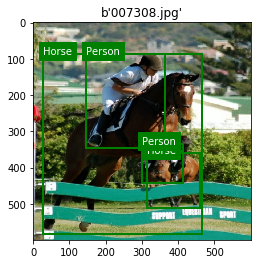

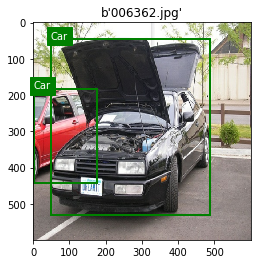

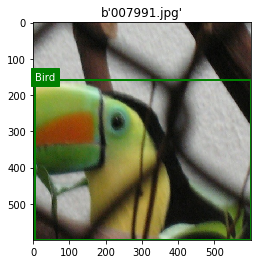

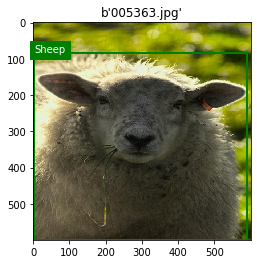

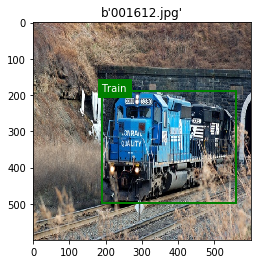

In [5]:
from matplotlib.font_manager import FontProperties

def bbox_perc_to_pixels(bbox):
    y_start, y_finish = bbox[0] * IMG_SIZE, bbox[2] * IMG_SIZE
    x_start, x_finish = bbox[1] * IMG_SIZE, bbox[3] * IMG_SIZE
    return y_start, x_start, y_finish, x_finish

for row in train.take(5):    
    _, ax = plt.subplots(1) # Create figure and axes
    image = row['image'].numpy().astype(float)
    ax.imshow(image)
    
    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        
        plt.text(x_start, y_start, classes[label], color='white', backgroundcolor='green')
    
    plt.title(row['filename'].numpy())
    plt.show()
    
    

At each sliding-window location, we simultanously predict multiple regions proposals:
1. "reg" layer has 4k outputs encoding the coordinates of k boxes (k=9: 3 shape ratios & 3 shape sizes)
    * the 4 outputs are: x, y, w & h: the box center coordinates and its width and height (see loss function)
2. "cls" layer outputs 2k scores that estimate probability of object or not for each proposal. (this is
    implemented  as a 2-class softmax layer)

In [ ]:
%%capture
# In preprocess_data.ipynb (in the same folder as this notebook) 
# it processes the values used for regression (distance from anchor to ground truth object) 
# and classification (intersection over union) labels used by the Region Proposing Network
%run preprocess_data.ipynb

In [ ]:
images_dataset = np.zeros((TRAIN_SIZE, IMG_SIZE, IMG_SIZE, 3))
for i, row in enumerate(train):
    images_dataset[i] = row['image'].numpy().astype(float)

In [ ]:
#BATCH_SIZE = 1
#def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#    ds = ds.cache()
#    ds = ds.repeat()  # Repeat forever    
#    #ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)    
#    ds = ds.batch(BATCH_SIZE)     
#    # dataset fetches batches in the background while the model is training.
#    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#    return ds
#train_it = prepare_for_training(train)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False # freeze the training
#tf.keras.utils.plot_model(base_model, show_shapes=True)

To increase performance we will train the top layers of the RegionProposalNetwork separately 
from the convolutional layers. We can do this because the conv. layers are frozen (their weights are not changed)

In [11]:
# 1. First we get the output of the convolutional layers for each of the train images:
convolutions_output = base_model.predict(images_dataset)

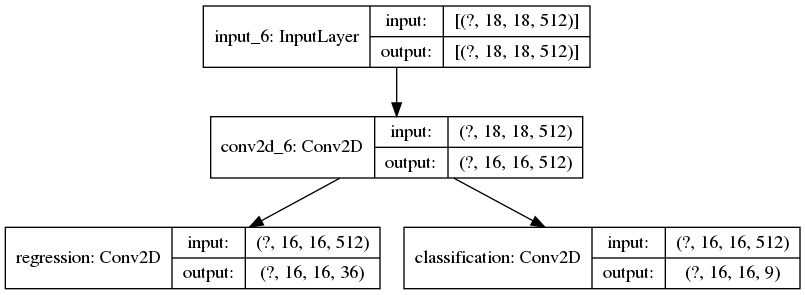

In [16]:
normalized_init = tf.compat.v1.keras.initializers.RandomNormal(mean=0.0, stddev=0.01) 

#https://www.tensorflow.org/guide/keras/functional
inputs = tf.keras.Input(shape=(18, 18, 512))

c = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', 
        bias_initializer='zeros', kernel_initializer=normalized_init)(inputs)

# TODO: I don't know what is the activation used in the paper here. I used sigmoid.
regression = tf.keras.layers.Conv2D(36, (1, 1), activation='sigmoid',
        bias_initializer='zeros', kernel_initializer=normalized_init, name='regression')(c)

classification = tf.keras.layers.Conv2D(9, (1, 1), activation='softmax',
        bias_initializer='zeros', kernel_initializer=normalized_init, name='classification')(c)

model = tf.keras.Model(inputs=inputs, outputs=[regression, classification])

tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss={'regression': 'mae', # TODO Is mse the right one?
                    'classification': 'binary_crossentropy'},
              metrics=['accuracy']) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 18, 18, 512) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 512)  2359808     input_6[0][0]                    
__________________________________________________________________________________________________
regression (Conv2D)             (None, 16, 16, 36)   18468       conv2d_6[0][0]                   
__________________________________________________________________________________________________
classification (Conv2D)         (None, 16, 16, 9)    4617        conv2d_6[0][0]                   
Total params: 2,382,893
Trainable params: 2,382,893
Non-trainable params: 0
________________

In [21]:
history = model.fit(x=convolutions_output,
                    y={'regression': regression_values_dataset,
                    'classification': },
                    batch_size=1,
                    epochs=10,
                    #validation_data=validation_batches
                   )

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 7s 72ms/sample - loss: 0.0732 - accuracy: 0.1430
Epoch 2/10
100/100 [==============================] - 7s 71ms/sample - loss: 0.0718 - accuracy: 0.0881
Epoch 3/10
100/100 [==============================] - 8s 76ms/sample - loss: 0.0699 - accuracy: 0.1504
Epoch 4/10
100/100 [==============================] - 7s 69ms/sample - loss: 0.0703 - accuracy: 0.1079
Epoch 5/10
100/100 [==============================] - 8s 76ms/sample - loss: 0.0705 - accuracy: 0.1353
Epoch 6/10
100/100 [==============================] - 7s 74ms/sample - loss: 0.0698 - accuracy: 0.1053
Epoch 7/10
100/100 [==============================] - 7s 75ms/sample - loss: 0.0696 - accuracy: 0.1471
Epoch 8/10
100/100 [==============================] - 8s 77ms/sample - loss: 0.0689 - accuracy: 0.1668
Epoch 9/10
100/100 [==============================] - 8s 81ms/sample - loss: 0.0694 - accuracy: 0.1363
Epoch 10/10
100/100 [==============================]

In [ ]:
Epoch 10/10 100/100 [==============================] - 8s 76ms/sample - loss: 0.0825

In [22]:
predictions = model.predict(convolutions_output[0:1])

In [23]:
print(predictions[0,0,10])
print(regression_values_dataset[0,0,10])
#model.layers[1].bias

[0.5055727  0.5291384  0.52232593 0.5274663  0.53182435 0.5245998
 0.50576866 0.5174357  0.5333549  0.5837899  0.5630596  0.53542066
 0.57219315 0.566356   0.53926194 0.5595122  0.5365873  0.52822316
 0.6503839  0.5652366  0.47852597 0.56861573 0.47982404 0.37663493
 0.64583915 0.5636776  0.47058663 0.6538724  0.57966214 0.48830447
 0.6614418  0.5705995  0.4838851  0.58362323 0.48452863 0.38424322]
[0.36813922 0.44243641 0.47958501 0.44243641 0.47958501 0.4981593
 0.36813922 0.44243641 0.47958501 0.78134761 0.64904061 0.5828871
 0.78134761 0.64904061 0.5828871  0.64904061 0.5828871  0.54981035
 0.65767745 0.57849598 0.4993145  0.57849598 0.4993145  0.42013303
 0.65767745 0.57849598 0.4993145  0.67152731 0.59234583 0.51316436
 0.67152731 0.59234583 0.51316436 0.59234583 0.51316436 0.43398289]


In [32]:
for i in range(10):
    model.evaluate(convolutions_output[i:i+1], regression_values_dataset[i:i+1])

1/1 [==============================] - 0s 33ms/sample - loss: 0.0689
